In [1]:
!pip install pytorch_model_summary

In [2]:

import random
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as Acivation
from sklearn.model_selection import train_test_split

from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from keras.datasets import  mnist
from keras.datasets import cifar10
from pytorch_model_summary import summary
import torch.nn.functional as F

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# import zipfile
# zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Research/Thesis (4 - II)/Classification/Data/Jahid/Data.zip', 'r')
# file = zip_ref.extractall("./tmp")
# zip_ref.close()

# print("o")

In [5]:
DATASET="/content/tmp"


In [6]:
CATEGORIES = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
        
train_data=[]

In [7]:
import os
import tensorflow as tf

import cv2
for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET,category)
        for img_file in os.listdir(path):
            img=cv2.imread(os.path.join(path,img_file),1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(224,224))            
            train_data.append([img,label])
            

print(len(train_data))

3637


In [8]:
random.shuffle(train_data)
random.shuffle(train_data)
random.shuffle(train_data)
random.shuffle(train_data)

In [9]:
for lbl in train_data[:10]:
    print(lbl[1])

2
2
1
1
3
1
2
1
0
1


In [10]:
X, y = [], []
for features,label in train_data:
    X.append(features)
    y.append(label)


In [11]:
len(X)

3637

In [12]:
X_arr = np.array(X).reshape(-1, 224,224,3)
y_arr = np.array(y)
X_arr.shape, y_arr.shape

((3637, 224, 224, 3), (3637,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, test_size=0.2, shuffle=True, random_state=9990)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2909, 224, 224, 3), (728, 224, 224, 3), (2909,), (728,))

In [14]:
class OCT_DATASET(Dataset):

    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        self.len = len(x)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        x_batch = self.x[index]
        y_batch = self.y[index]

        if self.transform is not None:
            x_batch = self.transform(x_batch)
        
        y_batch = torch.from_numpy(np.array(y_batch))

        return x_batch, y_batch


In [15]:

transform1 = transforms.Compose([
    #transforms.Resize(224, 224),
    transforms.ToTensor(),
    transforms.Normalize( (0.5, ), (0.5, ) )
])


train_dataset = OCT_DATASET(X_train, y_train, transform=transform1)
valid_dataset = OCT_DATASET(X_test, y_test, transform=transform1)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False)



dataiter = iter(train_loader)
images, label = dataiter.next()

print(images.shape, label.shape)


torch.Size([100, 3, 224, 224]) torch.Size([100])


In [16]:
class CNN(nn.Module):

    def __init__(self,vgg_features):
        super().__init__()

        self.features = vgg_features

    def forward(self, z):
        z = self.features(z)
        z = z.view(-1, 512*7*7)

        return z


class CNN_LSTM(nn.Module):

    def __init__(self, vgg_features):
        super(CNN_LSTM, self).__init__()
        self.cnn = CNN(vgg_features)
        self.rnn = nn.LSTM(
            input_size=512*7*7, 
            hidden_size=64, 
            num_layers=1,
            bidirectional = True,
            batch_first=True)
        self.linear = nn.Linear(64*2,4)

    def forward(self, x):
        #print(x.shape)
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        #print(self.rnn(r_in))
        r_out, h_n = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        
        return F.log_softmax(r_out2, dim=1)

In [17]:
vgg_f =  models.vgg16(pretrained=True).features
model_cnn = CNN(vgg_f)

# show output shape
print(summary(model_cnn, torch.zeros((1, 3, 224, 224)), show_input=False))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



--------------------------------------------------------------------------
      Layer (type)           Output Shape         Param #     Tr. Param #
          Conv2d-1      [1, 64, 224, 224]           1,792           1,792
            ReLU-2      [1, 64, 224, 224]               0               0
          Conv2d-3      [1, 64, 224, 224]          36,928          36,928
            ReLU-4      [1, 64, 224, 224]               0               0
       MaxPool2d-5      [1, 64, 112, 112]               0               0
          Conv2d-6     [1, 128, 112, 112]          73,856          73,856
            ReLU-7     [1, 128, 112, 112]               0               0
          Conv2d-8     [1, 128, 112, 112]         147,584         147,584
            ReLU-9     [1, 128, 112, 112]               0               0
      MaxPool2d-10       [1, 128, 56, 56]               0               0
         Conv2d-11       [1, 256, 56, 56]         295,168         295,168
           ReLU-12       [1, 256, 56

In [18]:
vgg_f =  models.vgg16(pretrained=True).features
model_cnn_lstm = CNN_LSTM(vgg_f)

# show output shape
print(summary(model_cnn_lstm, torch.zeros((1,1, 3, 224, 224)), show_input=False))

-------------------------------------------------------------------------------------------
      Layer (type)                            Output Shape         Param #     Tr. Param #
             CNN-1                              [1, 25088]      14,714,688      14,714,688
            LSTM-2     [1, 1, 128], [2, 1, 64], [2, 1, 64]      12,878,848      12,878,848
          Linear-3                                  [1, 4]             516             516
Total params: 27,594,052
Trainable params: 27,594,052
Non-trainable params: 0
-------------------------------------------------------------------------------------------


In [19]:
model = model_cnn_lstm.to(device)

In [20]:

# loss function and optimizer
model_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# training
loss_history = []
acc_history =  []
val_acc_history = []
val_loss_history = []
EPOCHS = 20

for e in range(EPOCHS):
    batch_loss = 0.0
    batch_acc = 0.0

    val_batch_loss = 0.0
    val_batch_acc = 0.0

    i = 0
    for x_bacth, y_batch in train_loader:
        i = i + 1
        optimizer.zero_grad() # set gradient to zero

        # print(x_train.shape)
        x_train = x_bacth.to(device) #x_bacth.view(x_bacth.shape[0], -1)
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], x_train.shape[3])
        y_batch = y_batch.to(device)
        y_pred = model.forward(x_train)
        # loss = model_loss(y_pred, y_batch)

        loss = F.nll_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(y_pred, 1)
        batch_loss = batch_loss + loss / len(train_loader)
        batch_acc = batch_acc + torch.sum(preds == y_batch.data) / ( len(train_loader) * 100 )

        print('Epoch: {} & Iteration: {} ~ = batch_loss: {:.4f}, batch_acc: {:.4f}'.format(e+1,i, batch_loss, batch_acc.item()))

    with torch.no_grad():
        i = 0
        for x_val, y_val in valid_loader:
            i = i+1
            # x_val =  x_val.view(x_val.shape[0], -1)
            x_val = x_val.to(device) #x_bacth.view(x_bacth.shape[0], -1)
            x_val = x_val.view(x_val.shape[0], 1,x_val.shape[1], x_val.shape[2], x_val.shape[3])
            y_val = y_val.to(device)

            y_pred = model.forward(x_val)
            val_loss = model_loss(y_pred, y_val)

            _, preds = torch.max(y_pred, 1)
            val_batch_loss = val_batch_loss + val_loss / len(valid_loader)
            val_batch_acc = val_batch_acc + torch.sum(preds == y_val.data) / (len(valid_loader) * 100)

            print('Epoch: {} & Iteration: {} ~ = val batch_loss: {:.4f}, val batch_acc: {:.4f}'.format(e+1,i, val_batch_loss, val_batch_acc.item()))




    epoch_loss = batch_loss
    epoch_acc = batch_acc.float()
    val_epoch_loss = val_batch_loss
    val_epoch_acc = val_batch_acc.float()

    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)
    val_acc_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)
    print('Epoch: {},~ = training_loss: {:.4f}, training_acc: {:.4f}; val_loss: {:.4f}, val_acc: {:.4f}'.format(e+1, epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))


Epoch: 1 & Iteration: 1 ~ = batch_loss: 0.0471, batch_acc: 0.0073
Epoch: 1 & Iteration: 2 ~ = batch_loss: 0.0934, batch_acc: 0.0160
Epoch: 1 & Iteration: 3 ~ = batch_loss: 0.1389, batch_acc: 0.0253
Epoch: 1 & Iteration: 4 ~ = batch_loss: 0.1837, batch_acc: 0.0363
Epoch: 1 & Iteration: 5 ~ = batch_loss: 0.2279, batch_acc: 0.0507
Epoch: 1 & Iteration: 6 ~ = batch_loss: 0.2719, batch_acc: 0.0650
Epoch: 1 & Iteration: 7 ~ = batch_loss: 0.3156, batch_acc: 0.0770
Epoch: 1 & Iteration: 8 ~ = batch_loss: 0.3588, batch_acc: 0.0917
Epoch: 1 & Iteration: 9 ~ = batch_loss: 0.4011, batch_acc: 0.1083
Epoch: 1 & Iteration: 10 ~ = batch_loss: 0.4426, batch_acc: 0.1257
Epoch: 1 & Iteration: 11 ~ = batch_loss: 0.4834, batch_acc: 0.1433
Epoch: 1 & Iteration: 12 ~ = batch_loss: 0.5230, batch_acc: 0.1650
Epoch: 1 & Iteration: 13 ~ = batch_loss: 0.5633, batch_acc: 0.1833
Epoch: 1 & Iteration: 14 ~ = batch_loss: 0.6021, batch_acc: 0.2013
Epoch: 1 & Iteration: 15 ~ = batch_loss: 0.6403, batch_acc: 0.2217
Epoc

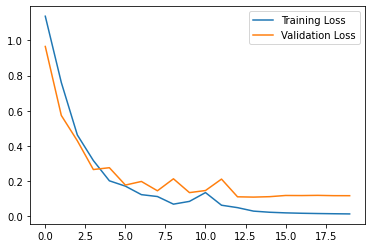

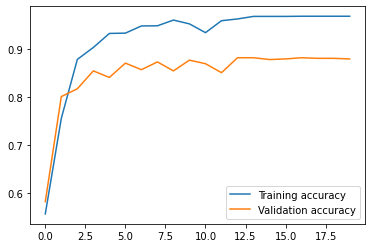

In [21]:
import matplotlib.pyplot as plt


plt.plot(loss_history,label='Training Loss')  
plt.plot(val_loss_history,label='Validation Loss')  
plt.legend()  
plt.show()  
plt.plot(acc_history,label='Training accuracy')  
plt.plot(val_acc_history,label='Validation accuracy')  
plt.legend()  
plt.show()  

In [23]:
PATH = '/content/drive/MyDrive/model_weights(VGG-BiLSTM).pth'
torch.save(model, PATH)

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import pandas as pd

In [31]:
for images, label in valid_loader:
    images = images.view(images.shape[0], 1,images.shape[1], images.shape[2], images.shape[3])

    output = model(images.to(device)).to(device)
    _,pred=torch.max(output,1)

    y_test = label.tolist()
    y_pred = pred.tolist()


    # Creates a confusion matrix
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                        index = CATEGORIES, 
                        columns = CATEGORIES)

    plt.figure(figsize=(5.5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('CNN-BiLSTM \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.savefig('foo.png')
    plt.show()

RuntimeError: ignored

# CM

In [37]:
dataiter = iter(valid_loader)
images, label = dataiter.next()

print(images.shape, label.shape)

torch.Size([100, 3, 224, 224]) torch.Size([100])


In [38]:
images = images.view(images.shape[0], 1,images.shape[1], images.shape[2], images.shape[3])
images.shape

torch.Size([100, 1, 3, 224, 224])

In [39]:
output = model(images.to(device)).to(device)
_,pred=torch.max(output,1)
print(pred[0].item())

RuntimeError: ignored

In [28]:
y_test = label.tolist()
y_pred = pred.tolist()

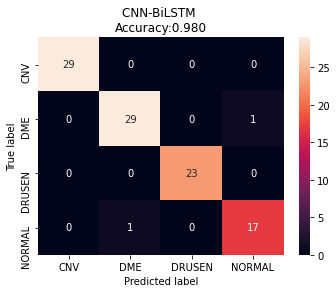

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import pandas as pd


# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = CATEGORIES, 
                     columns = CATEGORIES)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('CNN-BiLSTM \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('foo.png')
plt.show()

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,
                            target_names=CATEGORIES))

              precision    recall  f1-score   support

         CNV       1.00      1.00      1.00        29
         DME       0.97      0.97      0.97        30
      DRUSEN       1.00      1.00      1.00        23
      NORMAL       0.94      0.94      0.94        18

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



# Test

In [ ]:
import cv2

# compose allow us to chain multiple transform together
transform1 = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))

])

CATEGORIES = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
        
path = '/content/DME-30521-5.jpeg'
img = cv2.imread(path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(224,224))  
print(img.shape)


img = transform1(img)
print(img.shape)
image = img.view(1, 1, img.shape[0], img.shape[1], img.shape[2])
print(image.shape)


output = model(image.to(device)).to(device)
_,pred=torch.max(output,1)
print(pred[0].item())
print(CATEGORIES[pred[0].item()])